In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams['figure.dpi'] = 150
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import numpy as np
import pandas as pd
import pickle

import os
import requests
from io import BytesIO
from io import StringIO

from astropy.table import Table
from astropy.table import join
from astropy.io import ascii
import astropy.constants as c

#from scipy import interpolate
#from sklearn import svm

# Function to get NASA Exoplanet Archive catalogs 
# from Dan Foreman-Mackey (https://github.com/dfm/exopop)
def get_catalog(name, basepath="../data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
        
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

#To track the provenance of different columns, we want a function to prepend an informative string to each column name.
#We will do this before merging tables to make tracking the information easier.
def prepend_dataframe_columns(df, prefix):
    df.columns = [prefix+col for col in df.columns]
    return 


#Suppressing astropy units warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#Suppressing Pandas chained assignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

# Kepler Q1-Q17 DR25 official catalog of planet candidates

In [2]:
dr25 = get_catalog('q1_q17_dr25_koi')
prepend_dataframe_columns(dr25, 'dr25_')
dr25.head()

,dr25_kepid,dr25_kepoi_name,dr25_kepler_name,dr25_ra,dr25_ra_err,dr25_ra_str,dr25_dec,dr25_dec_err,dr25_dec_str,dr25_koi_gmag,...,dr25_koi_fpflag_co,dr25_koi_fpflag_ec,dr25_koi_insol,dr25_koi_insol_err1,dr25_koi_insol_err2,dr25_koi_srho,dr25_koi_srho_err1,dr25_koi_srho_err2,dr25_koi_fittype,dr25_koi_score
0,10811496,K00753.01,NaN,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,0,0,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.0
1,10848459,K00754.01,NaN,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,0,0,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.0
2,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,0,0,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.0
3,10872983,K00756.01,Kepler-228 d,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,114.81,112.85,-36.70,0.67324,0.33286,-0.38858,LS+MCMC,1.0
4,10872983,K00756.02,Kepler-228 c,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,427.65,420.33,-136.70,0.37377,0.74768,-0.26357,LS+MCMC,1.0


In [3]:
dr25['multi_flag'] = np.zeros(len(dr25))

for i in range(len(dr25)):
    _kic = dr25['dr25_kepid'].iloc[i]
    _arg = dr25['dr25_kepid'] == _kic
    dr25['multi_flag'].iloc[i] = len(dr25['dr25_kepoi_name'][_arg])

# Berger et al. 2018 planet parameters

In [4]:
b18 = Table.read("http://cdsarc.unistra.fr/ftp/J/ApJ/866/99/table2.dat",
                   readme="http://cdsarc.unistra.fr/ftp/J/ApJ/866/99/ReadMe",
                   format="ascii.cds")

b18 = b18.to_pandas()
prepend_dataframe_columns(b18, 'b18_')
b18.head()

,b18_KIC,b18_KOI,b18_Rp,b18_E_Rp,b18_e_Rp,b18_Fp,b18_E_Fp,b18_e_Fp,b18_Bin
0,10797460,K00752.01,2.316,0.156,0.134,104.641,8.011,7.367,0
1,10797460,K00752.02,2.898,0.955,0.207,10.186,0.780,0.717,0
2,10854555,K00755.01,2.308,0.410,0.230,652.435,55.222,50.242,0
3,10872983,K00756.01,4.600,0.721,0.334,122.778,14.831,13.014,0
4,10872983,K00756.02,3.268,0.341,0.337,457.318,55.241,48.473,0


# Berger et al. 2020 planet parameters

In [5]:
b20 = Table.read("http://cdsarc.unistra.fr/ftp/J/AJ/160/108/table1.dat",
                 readme="http://cdsarc.unistra.fr/ftp/J/AJ/160/108/ReadMe",
                 format="ascii.cds")

b20 = b20.to_pandas()
prepend_dataframe_columns(b20, 'b20_')
b20['b20_KOI'] = ['K'+str(k).zfill(8) for k in b20['b20_KOI']]
b20.head()

,b20_KIC,b20_KOI,b20_PD,b20_Radius,b20_E_Radius,b20_e_Radius,b20_a,b20_E_a,b20_e_a,b20_Flux,b20_E_Flux,b20_e_Flux,b20_ZAMSFlux,b20_Flag
0,11446443,K00001.01,CONFIRMED,14.21,0.29,0.29,0.0355,0.0008,0.0008,854.78,69.34,64.81,524.75,AO
1,10666592,K00002.01,CONFIRMED,16.45,0.35,0.34,0.0381,0.0005,0.0006,4285.95,331.23,336.99,2394.68,AO
2,10748390,K00003.01,CONFIRMED,4.88,0.08,0.07,0.0516,0.0006,0.0004,86.58,5.24,4.73,58.22,NaN
3,3861595,K00004.01,CONFIRMED,13.18,0.42,0.82,0.0583,0.0007,0.0015,5244.42,478.90,520.46,3647.63,AO
4,11853905,K00007.01,CONFIRMED,4.01,0.10,0.10,0.0455,0.0007,0.0010,1247.17,99.09,99.02,719.80,NaN


# Berger et al. 2020 stellar parameters

In [6]:
b20_t2 = pd.read_parquet('./data/GKSPCPapTable2.parquet')

b20 = b20.merge(b20_t2, 
                how='left',
                left_on='b20_KIC',
                right_on='b20_KIC')

b20.head()

,b20_KIC,b20_KOI,b20_PD,b20_Radius,b20_E_Radius,b20_e_Radius,b20_a,b20_E_a,b20_e_a,b20_Flux,...,b20_iso_age_err2,b20_iso_dis,b20_iso_dis_err1,b20_iso_dis_err2,b20_iso_avs,b20_iso_gof,b20_TAMS,b20_log10_iso_age,b20_E_log10_iso_age,b20_e_log10_iso_age
0,11446443,K00001.01,CONFIRMED,14.21,0.29,0.29,0.0355,0.0008,0.0008,854.78,...,-3.22,214.8,3.8,-3.7,0.000,1.0000,10.93,9.790285,0.202268,0.320463
1,10666592,K00002.01,CONFIRMED,16.45,0.35,0.34,0.0381,0.0005,0.0006,4285.95,...,-0.38,340.2,5.8,-6.2,0.262,1.0000,2.68,9.240549,0.087830,0.107010
2,10748390,K00003.01,CONFIRMED,4.88,0.08,0.07,0.0516,0.0006,0.0004,86.58,...,-5.58,37.3,0.6,-0.6,0.000,1.0000,32.98,10.190332,0.078246,0.193820
3,3861595,K00004.01,CONFIRMED,13.18,0.42,0.82,0.0583,0.0007,0.0015,5244.42,...,-0.11,782.4,22.3,-21.6,0.433,0.9915,1.42,9.079181,0.091080,0.041755
4,11853905,K00007.01,CONFIRMED,4.01,0.10,0.10,0.0455,0.0007,0.0010,1247.17,...,-1.01,485.7,10.9,-9.8,0.124,1.0000,5.32,9.594393,0.164519,0.129010


# CKS VII (Fulton & Petigura 2018)

In [7]:
#CKS VII stellar parameters table
cks_t2 = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/AJ/156/264/table2.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/AJ/156/264/ReadMe",
                 format="ascii.cds")

#CKS VII planet parameters table
cks_t3 = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/AJ/156/264/table3.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/AJ/156/264/ReadMe",
                 format="ascii.cds")

cks_t3['KOI_star'] = [k.split(".")[0] for k in cks_t3['KOI']]

cks_t2 = cks_t2.to_pandas()
cks_t3 = cks_t3.to_pandas()
cks_t2 = cks_t2.rename(columns={"KOI": "KOI_star"})

cks = cks_t3.merge(cks_t2, how='left', left_on='KOI_star', right_on='KOI_star')

prepend_dataframe_columns(cks, 'cks_')

cks.head()

,cks_KOI,cks_Per,cks_E_Per,cks_e_Per,cks_Rp/R*,cks_E_Rp/R*,cks_e_Rp/R*,cks_Rp,cks_E_Rp,cks_e_Rp,...,cks_E_rhoiso,cks_e_rhoiso,cks_logAiso,cks_E_logAiso,cks_e_logAiso,cks_plxspec,cks_E_plxspec,cks_e_plxspec,cks_r8,cks_RCF
0,K00001.01,2.470613,1.900000e-08,1.900000e-08,0.123851,0.000025,0.000076,14.141,0.331,0.331,...,0.04,0.04,9.74,0.13,0.15,4.756,0.320,0.474,1.000,1.0102
1,K00002.01,2.204735,3.800000e-08,3.800000e-08,0.075408,0.000008,0.000007,16.250,0.349,0.349,...,0.01,0.00,9.25,0.04,0.05,3.661,0.411,0.586,1.001,1.0034
2,K00006.01,1.334104,7.070000e-07,7.070000e-07,0.294016,0.103683,0.209459,41.936,22.239,22.239,...,0.03,0.03,9.32,0.09,0.24,2.201,0.127,0.212,1.007,1.0006
3,K00007.01,3.213669,1.122000e-06,1.122000e-06,0.024735,0.000141,0.000076,4.076,0.107,0.107,...,0.02,0.02,9.78,0.09,0.08,2.112,0.228,0.274,1.000,NaN
4,K00008.01,1.160153,4.270000e-07,4.270000e-07,0.018559,0.000246,0.001678,1.896,0.110,0.110,...,0.03,0.05,9.18,0.26,0.52,2.895,0.127,0.192,1.001,NaN


# Martinez et al. 2019 independent spectroscopic analysis of CKS sample

In [8]:
m19_st = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/ApJ/875/29/table1.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/ApJ/875/29/ReadMe",
                 format="ascii.cds")

m19_pl = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/ApJ/875/29/table2.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/ApJ/875/29/ReadMe",
                 format="ascii.cds")

m19_pl['KOI_star'] = [k.split(".")[0] for k in m19_pl['KOI']]

m19_st = m19_st.to_pandas()
m19_pl = m19_pl.to_pandas()
m19_st = m19_st.rename(columns={"Name": "KOI_star"})

m19 = m19_pl.merge(m19_st, how='left', left_on='KOI_star', right_on='KOI_star')

prepend_dataframe_columns(m19, 'm19_')
m19.head()

,m19_Seq_x,m19_KOI,m19_Rp,m19_e_Rp,m19_KOI_star,m19_Seq_y,m19_Teff,m19_e_Teff,m19_log(g),m19_e_log(g),m19_Vturb,m19_e_Vturb,m19_R*,m19_e_R*
0,1,K00001.01,13.62,0.30,K00001,35,5856,33,4.44,0.09,1.15,0.06,1.05,0.02
1,2,K00002.01,17.93,1.07,K00002,154,6384,77,3.90,0.13,1.98,0.10,2.01,0.12
2,3,K00007.01,4.49,0.13,K00007,337,5852,20,4.19,0.06,1.20,0.03,1.52,0.04
3,4,K00010.01,16.62,1.14,K00010,947,6118,120,4.09,0.14,1.89,0.20,1.59,0.11
4,5,K00017.01,14.31,0.35,K00017,467,5699,22,4.34,0.07,1.02,0.04,1.28,0.03


# Merge the DR25 dataframe with the GKSPC and CKS catalogs

In [9]:
dr25 = dr25.merge(b20, 
                  how='left', 
                  left_on='dr25_kepoi_name',
                  right_on='b20_KOI')

dr25 = dr25.merge(b18, 
                  how='left', 
                  left_on='dr25_kepoi_name',
                  right_on='b18_KOI')

dr25 = dr25.merge(cks, 
                  how='left', 
                  left_on='dr25_kepoi_name',
                  right_on='cks_KOI')

dr25 = dr25.merge(m19, 
                  how='left', 
                  left_on='dr25_kepoi_name',
                  right_on='m19_KOI')

# Sample selection

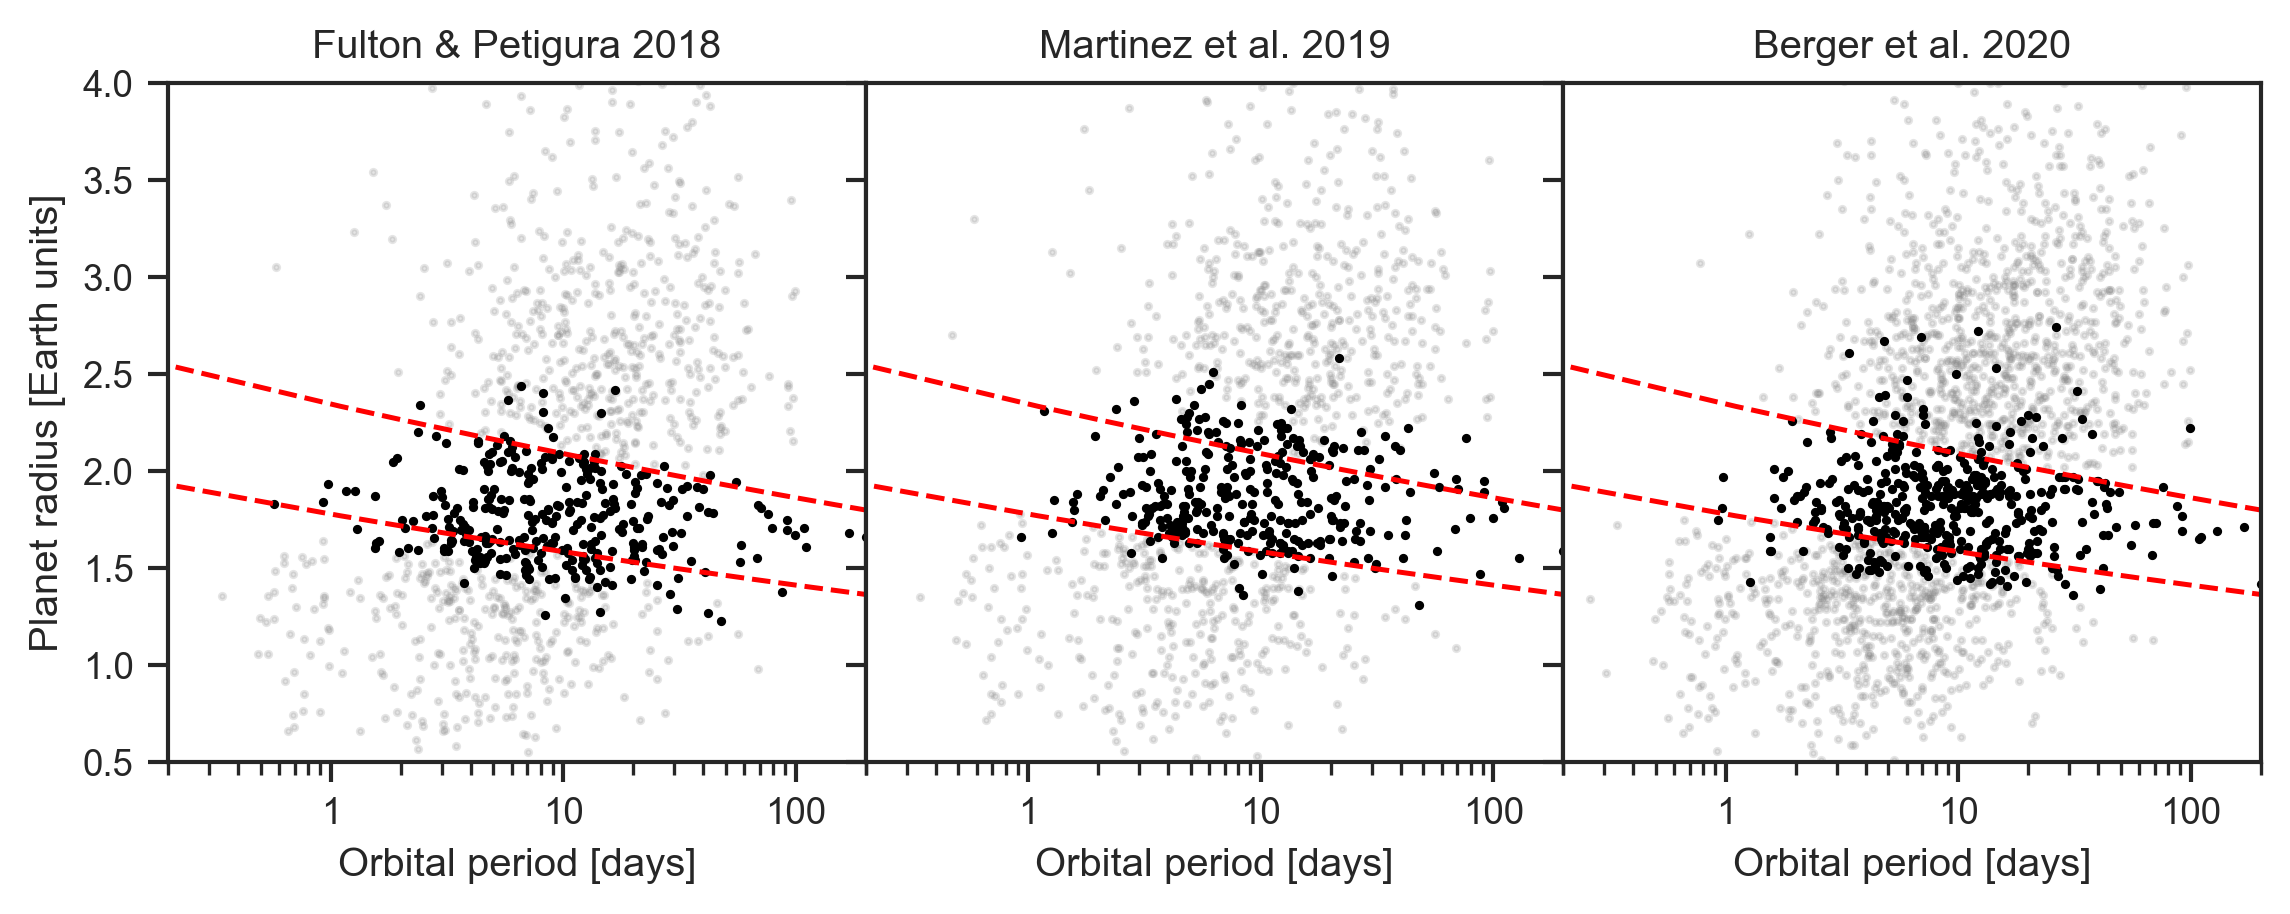

In [10]:
def radius_gap(period,
               alpha=-0.05,
               beta=0.31,
               gamma=0.06):
    
    center = alpha*np.log10(period) + beta
    upper  = 10.**(center + gamma*np.sqrt(1.0+alpha**2.))
    lower  = 10.**(center - gamma*np.sqrt(1.0+alpha**2.))
    
    return upper, lower


#For plotting purposes
pgap = np.linspace(0.1,1000,1000)
rgap_hi, rgap_lo = radius_gap(pgap)

arg = (dr25.dr25_koi_score>0.99)
arg &= (dr25.dr25_koi_disposition!='FALSE POSITIVE')
arg &= (dr25.dr25_koi_period<100)
#arg &= (dr25.cks_r8<1.2)
#arg &= (dr25.cks_RCF<1.05)
#arg &= (dr25.dr25_koi_gmag<16)
#arg &= abs(dr25.cks_R/dr25.b20_iso_rad - 1)<0.1
#arg &= abs(dr25['m19_R*']/dr25.b20_iso_rad - 1)<0.1

in_the_gap = arg & (dr25.b20_Radius < radius_gap(dr25.dr25_koi_period)[0]) & (dr25.b20_Radius > radius_gap(dr25.dr25_koi_period)[1])
in_the_gap |= (dr25.cks_Rp < radius_gap(dr25.dr25_koi_period)[0]) & (dr25.cks_Rp > radius_gap(dr25.dr25_koi_period)[1])
in_the_gap |= (dr25.m19_Rp < radius_gap(dr25.dr25_koi_period)[0]) & (dr25.m19_Rp > radius_gap(dr25.dr25_koi_period)[1])


sc_kwargs = {"alpha":0.2, "s":2}

fig,ax = plt.subplots(nrows=1, 
                      ncols=3,
                      figsize=(9,3), 
                      sharex=True, sharey=True)

planet_radii = [dr25.cks_Rp, dr25.m19_Rp, dr25.b20_Radius]
ref_labels = ['Fulton & Petigura 2018',
              'Martinez et al. 2019',
              'Berger et al. 2020']

for i,p in enumerate(planet_radii):
    ax[i].scatter(dr25.dr25_koi_period[arg], p[arg], **sc_kwargs, color='grey')
    ax[i].scatter(dr25.dr25_koi_period[in_the_gap], p[in_the_gap], s=2, color='k')
    ax[i].plot(pgap, rgap_hi, 'r--')
    ax[i].plot(pgap, rgap_lo, 'r--')    
    ax[i].set_ylim(0.5,4)
    ax[i].set_xlim(0.2,200)    
    ax[i].semilogx()    
    ax[i].set_xlabel('Orbital period [days]')
    ax[i].set_title(ref_labels[i])
    ax[i].set_xticks([1,10,100])
    ax[i].set_xticklabels(['1','10','100'])
    
ax[0].set_ylabel('Planet radius [Earth units]')

plt.subplots_adjust(wspace=0)
plt.show()

In [11]:
df = dr25[in_the_gap]
df.head()

,dr25_kepid,dr25_kepoi_name,dr25_kepler_name,dr25_ra,dr25_ra_err,dr25_ra_str,dr25_dec,dr25_dec_err,dr25_dec_str,dr25_koi_gmag,...,m19_KOI_star,m19_Seq_y,m19_Teff,m19_e_Teff,m19_log(g),m19_e_log(g),m19_Vturb,m19_e_Vturb,m19_R*,m19_e_R*
6,10872983,K00756.03,Kepler-228 b,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,K00756,1191.0,5714.0,65.0,4.51,0.08,1.35,0.12,1.14,0.04
10,5436502,K00834.04,Kepler-238 b,287.89713,0.0,19h11m35.31s,40.637821,0.0,+40d38m16.2s,15.600,...,K00834,1210.0,5911.0,46.0,4.35,0.11,1.51,0.07,1.61,0.06
20,8150320,K00904.01,Kepler-55 d,285.16833,0.0,19h00m40.40s,44.026459,0.0,+44d01m35.3s,16.820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,5880320,K01060.02,Kepler-758 c,293.08463,0.0,19h32m20.31s,41.135441,0.0,+41d08m07.6s,14.645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,5880320,K01060.04,Kepler-758 e,293.08463,0.0,19h32m20.31s,41.135441,0.0,+41d08m07.6s,14.645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
np.shape(df)

(483, 272)

In [13]:
df.to_csv('./data/sample.csv')